In [31]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [32]:
from _negative_volume_index import NegativeVolumeIndex

In [33]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [34]:
data=pd.read_csv("MASI_2.csv",parse_dates=True, index_col=0)

In [35]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2002-01-03,3684.51,3694.96,3640.00,3640.00,0,MAD
2002-01-04,3641.08,3671.50,3640.00,3671.50,0,MAD
2002-01-07,3670.56,3674.71,3662.56,3667.30,0,MAD
2002-01-08,3655.56,3657.54,3639.32,3641.65,0,MAD
2002-01-09,3637.89,3645.03,3627.77,3644.19,0,MAD
...,...,...,...,...,...,...
2022-05-16,12682.21,12738.15,12648.59,12682.77,0,MAD
2022-05-17,12682.77,12733.07,12681.66,12716.65,0,MAD
2022-05-18,12716.65,12749.42,12672.62,12679.96,0,MAD


In [36]:
df=data["Close"]
high=data["High"]
low=data["Low"]



In [37]:
data["Volume"]=data["Close"]

## Fonction

In [38]:
premier=0 

In [39]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [40]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

In [41]:
nvi=NegativeVolumeIndex(data)

In [42]:
nvi._calculateTi(period=255)

,Date,NVI
0,2002-01-03,NaN
1,2002-01-04,NaN
2,2002-01-07,NaN
3,2002-01-08,NaN
4,2002-01-09,NaN
...,...,...
5076,2022-05-16,0.007578
5077,2022-05-17,0.007562
5078,2022-05-18,0.007546
5079,2022-05-19,0.007530


In [43]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [18]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

In [52]:
def obj_nvi(period):
    period=int(period[0])
    signal=pd.DataFrame(index=df.index)
    signal["compa"]=np.nan 
    #nv=at.nvi(df,vol)
    nv=nvi._calculateTi(period)["NVI"]
    nvis=pd.Series(nv.rolling(period).mean(), name="NVIsignal")
    signal["compa"][period:]=np.where(nv[period:] > nvis[period:] ,1,0)
    signal["signal"]=adjustsignal(signal["compa"].diff())
    cours=df*(1+taux*signal["signal"])
    pmval=pmv(cours,signal["signal"])
    return pmval.max(),

gen	nevals	max	avg
0  	40    	0  	0  
1  	36    	0  	0  
2  	38    	0  	0  
3  	37    	0  	0  
4  	36    	0  	0  
5  	37    	0  	0  
Hall of Fame Individuals = 
[23]
[10]
[41]
[45]
[37]
Best Ever Individual =  [23]


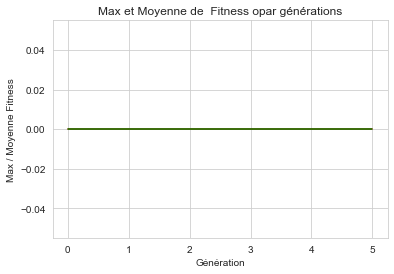

In [53]:
GeneticAlgo(1,obj_nvi,5,8,50)